The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


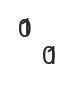

In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import CDR3bVAE, PairedFVAE
from src.metrics import reconstruction_accuracy, VAELoss, PairedVAELoss
from src.datasets import CDR3BetaDataset, PairedDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

In [4]:
df = pd.read_csv('../data/filtered/230927_nettcr_positives_only.csv')
df.head()

,A1,A2,A3,B1,B2,B3,binder,peptide,original_peptide,TRAV,...,TRBJ,partition,Unnamed: 0,allele,origin,original_index,TRBV_gene,TRBJ_gene,TRA_CDR3,TRB_CDR3
0,KALYS,LLKGGEQ,GTEIGGGTSYGKLT,MNHEY,SMNVEV,ASGTETQY,1,KLGGALQAK,KLGGALQAK,TRAV30*01,...,TRBJ2-5*01,2,32208.0,HLA-A*03:01,10x,2627.0,TRBV27,TRBJ2-5,CGTEIGGGTSYGKLTF,CASGTETQYF
1,DRGSQS,IYSNGD,AVNPANARLM,DFQATT,SNEGSKA,SARWGGGTDTQY,1,ELAGIGILTV,ELAGIGILTV,TRAV12-2*01,...,TRBJ2-3*01,3,37123.0,HLA-A*02:01,10x,3820.0,TRBV20-1,TRBJ2-3,CAVNPANARLMF,CSARWGGGTDTQYF
2,TSGFNG,NVLDGL,AVGDDKII,DFQATT,SNEGSKA,SARGLDRGTNEQY,1,AVFDRKSDAK,AVFDRKSDAK,TRAV1-2*01,...,TRBJ2-7*01,3,14961.0,HLA-A*11:01,10x,3592.0,TRBV20-1,TRBJ2-7,CAVGDDKIIF,CSARGLDRGTNEQYF
3,DRGSQS,IYSNGD,AVTPGTYKYI,LGHDT,YNNKEL,ASSPGTSIFVAEQY,1,ELAGIGILTV,ELAGIGILTV,TRAV12-2*01,...,TRBJ2-7*01,0,8197.0,HLA-A*02:01,10x,5933.0,TRBV3-1,TRBJ2-7,CAVTPGTYKYIF,CASSPGTSIFVAEQYF
4,TRDTTYY,RNSFDEQN,AFLYNQGGKLI,SGHDY,FNNNVP,ASSPGSRGNIQY,1,RAKFKQLL,RAKFKQLL,TRAV19*01,...,TRBJ2-4*01,1,23616.0,HLA-B*08:01,10x,2745.0,TRBV12-4,TRBJ2-4,CAFLYNQGGKLIF,CASSPGSRGNIQYF


In [5]:
df['TRB_CDR3'].apply(len).max(), df['TRA_CDR3'].apply(len).max(), df['peptide'].apply(len).max()

(25, 24, 12)

# paired model / datasets

In [141]:
from src.models import PairedFVAE
from src.datasets import PairedDataset
from torch.utils.data import SequentialSampler
sample = df.sample(3)
dataset = PairedDataset(sample, 23, 25, 12, pad_scale=-20, use_a=True, use_b=True, use_pep=True, cdr3b_col='TRB_CDR3', cdr3a_col='TRA_CDR3')
loader = dataset.get_dataloader(5, SequentialSampler)
model = PairedFVAE(max_len_b=23, max_len_a=25, max_len_pep=12, use_a=True, use_b=True, use_pep=True, use_v=False, use_j=False, hidden_dim=10, latent_dim=5)

In [142]:
# checking the slicing etc works
x_true = dataset.x
x_hat, mu, logvar = model(x_true)
seq_hat, v_hat, j_hat = model.reconstruct_hat(x_hat)
seq_true, v_true, j_true = model.reconstruct_hat(x_true)

In [145]:
seq_hat

tensor([[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16,  0, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16,  0, 16, 16, 16, 16],
        [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16,  0, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16,  0, 16, 16, 16, 16],
        [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16, 16]])

In [117]:
from src.metrics import reconstruction_accuracy
reconstruction_accuracy(seq_true, seq_hat)

(0.082269087433815, 0, 0)

In [118]:
mask=(seq_true!=20).float()
true_lens=mask.sum(dim=1)
((seq_true==seq_hat).float() * mask)[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0.])

In [59]:
from src.data_processing import AA_KEYS
from random import randint

def apply_mutation(seq, n):
    seq = list(seq)  # Convert the sequence to a list of characters
    prev_idx = None
    idx = prev_idx
    for _ in range(n):
        while idx == prev_idx:
            idx = randint(0, len(seq) - 1)
        letter = seq[idx]
        while letter == seq[idx]:
            letter = AA_KEYS[randint(0, len(AA_KEYS) - 1)]
        seq[idx] = letter
        prev_idx = idx

    return ''.join(seq)  # Convert the list of characters back to a string

seq = 'CSASDNMVGAYEQYF'
mutated_seq = apply_mutation(seq, 3)
print(seq)
print(mutated_seq)


CSASDNMVGAYEQYF
CSAEDNMIGANEQYF


In [146]:

# Doing a fake dataset with small mutations and check the reconstruction accuracy
false_sample = sample.copy()
false_sample['TRB_CDR3'] = false_sample['TRB_CDR3'].apply(apply_mutation, n=6)
false_sample['TRA_CDR3'] = false_sample['TRA_CDR3'].apply(apply_mutation, n=7)
false_sample['peptide'] = false_sample['peptide'].apply(apply_mutation, n=2)
dataset = PairedDataset(sample, 23, 25, 12, pad_scale=-20, use_a=True, use_b=True, use_pep=True, cdr3b_col='TRB_CDR3', cdr3a_col='TRA_CDR3')
loader = dataset.get_dataloader(5, SequentialSampler)
false_dataset = PairedDataset(false_sample, 23, 25, 12, pad_scale=-20, use_a=True, use_b=True, use_pep=True, cdr3b_col='TRB_CDR3', cdr3a_col='TRA_CDR3')
x_true = dataset.x
x_hat = false_dataset.x

seq_hat, v_hat, j_hat = model.reconstruct_hat(x_hat)
seq_true, v_true, j_true = model.reconstruct_hat(x_true)
reconstruction_accuracy(seq_true, seq_hat)

(0.6213971972465515, 0, 0)

In [124]:
model = PairedFVAE(23,25,12,use_pep=True, use_v=False, use_j=False)
x_seq_recon, _, _ = model.slice_x(x_hat)
x_seq_true, _, _ = model.slice_x(x_true)


In [151]:
seq_hat.shape

torch.Size([3, 60])

In [196]:
from src.models import PairedFVAE
max_len_b=0
max_len_a=25
max_len_pep=12
use_b=False
use_a=True
use_pep=True
dataset = PairedDataset(sample, max_len_b, max_len_a, max_len_pep, pad_scale=-20, use_a=use_a, use_b=use_b, use_pep=use_pep, cdr3b_col='TRB_CDR3', cdr3a_col='TRA_CDR3')
loader = dataset.get_dataloader(len(sample), SequentialSampler)
x_true = dataset.x
model = PairedFVAE(max_len_b, max_len_a, max_len_pep, use_b=use_b, use_a=use_a, use_pep=use_pep)
seq_true, v_true, j_true = model.reconstruct_hat(x_true)
print(seq_true[:, :max_len_b].shape, seq_true[:, max_len_b:max_len_b+max_len_a], seq_true[:, max_len_b+max_len_a:])
results = predict_model(model, dataset, loader)

torch.Size([3, 0]) tensor([[ 4.,  9.,  1., 15.,  7.,  0.,  7., 15., 18.,  5., 10., 16., 13., 20.,
         20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.],
        [ 4.,  0., 19., 15.,  7.,  7., 18.,  5., 11., 19., 16., 13., 20., 20.,
         20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.],
        [ 4.,  0., 12., 15.,  7.,  6.,  7.,  7., 15.,  5.,  7.,  2., 10.,  9.,
         13., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.]]) tensor([[ 0., 19., 13.,  3.,  1., 11., 15.,  3.,  0., 11., 20., 20.],
        [ 6., 10.,  0.,  7.,  9.,  7.,  9., 10., 16., 19., 20., 20.],
        [ 7.,  9., 10.,  7., 13., 19., 13., 16., 10., 20., 20., 20.]])


In [206]:
model

CDR3bVAE(
  (encoder): Sequential(
    (0): Linear(in_features=511, out_features=255, bias=True)
    (1): SELU()
    (2): Linear(in_features=255, out_features=128, bias=True)
    (3): SELU()
  )
  (encoder_mu): Linear(in_features=128, out_features=32, bias=True)
  (encoder_logvar): Linear(in_features=128, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SELU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): SELU()
  )
  (decoder_sequence): Sequential(
    (0): Linear(in_features=128, out_features=255, bias=True)
    (1): SELU()
    (2): Linear(in_features=255, out_features=460, bias=True)
  )
  (decoder_v): Linear(in_features=128, out_features=51, bias=True)
)

In [213]:
from src.models import CDR3bVAE
from src.datasets import CDR3BetaDataset
max_len_b=23
dataset = CDR3BetaDataset(sample, max_len_b, use_v=True, use_j=False, pad_scale=-20,v_dim=51,cdr3b_col='TRB_CDR3')
loader = dataset.get_dataloader(len(sample), SequentialSampler)
x_true = dataset.x
model = CDR3bVAE(max_len_b, use_v=True, use_j=False, v_dim=51)
seq_true, v_true, j_true = model.reconstruct_hat(x_true)
results2 = predict_model(model, dataset, loader)

23


In [219]:
args = {}
args['cdr3a_col']='123'
args['cdr3b_col']='None'
args['use_a'] = not (args['cdr3a_col']=="None")
args['use_b'] = not (args['cdr3b_col']=="None")

In [222]:
ntm = {'x':0.125, 'b':.623, 'c':.2350}
np.sum([x for x in ntm.values()])

0.983

# Concat model

In [31]:
df['A2'].apply(len).max()

8

In [32]:
from src.data_processing import encode_batch

b3 = encode_batch(df['B3'], max_len=23, encoding='BL50LO', pad_scale=-20)
a3 = encode_batch(df['A3'], max_len=22, encoding='BL50LO', pad_scale=-20)
a2 = encode_batch(df['B2'], max_len=8, encoding='BL50LO', pad_scale=-20)
b2 = encode_batch(df['B2'], max_len=7, encoding='BL50LO', pad_scale=-20)

In [54]:
print('A1', df['A1'].apply(len).max())
print('A2', df['A2'].apply(len).max())
print('A3', df['A3'].apply(len).max())
print('B1', df['B1'].apply(len).max())
print('B2', df['B2'].apply(len).max())
print('B3', df['B3'].apply(len).max())

A1 7
A2 8
A3 22
B1 6
B2 7
B3 23


In [59]:
cat_first = torch.cat([b3, a3], dim=1).flatten(start_dim=1)
flat_first = torch.cat([b3.flatten(start_dim=1), a3.flatten(start_dim=1)], dim=1)
assert (cat_first==flat_first).all(), 'Wrong'

In [18]:
flat_first.view(-1, 23+22, 20)[0]

tensor([[  5.,  -2.,  -1.,  -2.,  -1.,  -1.,  -1.,   0.,  -2.,  -1.,  -2.,  -1.,
          -1.,  -3.,  -1.,   1.,   0.,  -3.,  -2.,   0.],
        [  1.,  -1.,   1.,   0.,  -1.,   0.,  -1.,   0.,  -1.,  -3.,  -3.,   0.,
          -2.,  -3.,  -1.,   5.,   2.,  -4.,  -2.,  -2.],
        [  0.,  -3.,   0.,  -1.,  -3.,  -2.,  -3.,   8.,  -2.,  -4.,  -4.,  -2.,
          -3.,  -4.,  -2.,   0.,  -2.,  -3.,  -3.,  -4.],
        [  0.,  -1.,   0.,  -1.,  -1.,  -1.,  -1.,  -2.,  -2.,  -1.,  -1.,  -1.,
          -1.,  -2.,  -1.,   2.,   5.,  -3.,  -2.,   0.],
        [ -1.,   0.,   0.,   2.,  -3.,   2.,   6.,  -3.,   0.,  -4.,  -3.,   1.,
          -2.,  -3.,  -1.,  -1.,  -1.,  -3.,  -2.,  -3.],
        [  0.,  -1.,   0.,  -1.,  -1.,  -1.,  -1.,  -2.,  -2.,  -1.,  -1.,  -1.,
          -1.,  -2.,  -1.,   2.,   5.,  -3.,  -2.,   0.],
        [ -1.,   1.,   0.,   0.,  -3.,   7.,   2.,  -2.,   1.,  -3.,  -2.,   2.,
           0.,  -4.,  -1.,   0.,  -1.,  -1.,  -1.,  -3.],
        [ -2.,  -1.,  -2., 

In [57]:
from src.models import CDR3bVAE, FullTCRVAE
model = CDR3bVAE(max_len = 23+22, pad_scale=-20, use_v=False, use_j=False)
seq_hat, _, _ = model.reconstruct_hat(flat_first)
seq, v, j = model.slice_x(flat_first)
(seq_hat != 20).float()

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])

In [42]:
max_len_a1=0
max_len_a2=0
max_len_a3=0
max_len_b1=0
max_len_b2=0
max_len_b3=0

assert not all([x==0 for x in [max_len_a1, max_len_a2, max_len_a3, max_len_b1, max_len_b2, max_len_b3]]), 'xd'

AssertionError: xd

In [68]:
from src.models import FullTCRVAE
from src.datasets import FullTCRDataset
from torch.utils.data import SequentialSampler
fulltcr_dataset = FullTCRDataset(df, 7, 8, 22, 6, 7, 23, pad_scale=-20)
fulltcr_loader = fulltcr_dataset.get_dataloader(1024, SequentialSampler)
fulltcr_model = FullTCRVAE()

In [74]:
fulltcr_model.to(torch.device('cuda:0'))

AssertionError: Torch not compiled with CUDA enabled